In [1]:
# ===========================================================
# Batch Reactor Scale-up Model (CAChE compatible)
# Author: AristEng adaptation
# ===========================================================

from dataclasses import dataclass
from typing import Tuple, Dict
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
from ipywidgets import interact


# ===========================================================
# Reactor class (original unit system: cm, min, molar Cp)
# ===========================================================
@dataclass
class Reactor:
    h_cm: float              # reactor height = diameter (cm)
    Ta: float                # cooling temperature (K)
    adiabatico: bool = False

    # Global constants (original values)
    T0: float = 323.0        # initial temperature [K]
    k0_min: float = 3e3      # pre-exponential [1/min]
    E: float = 30000.0       # activation energy [J/mol]
    R: float = 8.314         # gas constant [J/mol/K]
    Ca0: float = 0.015       # initial concentration [mol/cm³]
    DH: float = -25000.0     # reaction enthalpy [J/mol] (exothermic)
    Cp_molar: float = 125.0  # molar heat capacity [J/mol/K]
    U_J_cm2_K_min: float = 2.4  # heat-transfer coefficient [J/(cm²·K·min)]

    # ---------------- Geometry ----------------
    def area_cm2(self) -> float:
        """Total external area [cm²]."""
        h = self.h_cm
        return (np.pi / 4.0) * h**2 + (np.pi) * h**2  # (π/4 h²) + (π h²)

    def volume_cm3(self) -> float:
        """Reactor volume [cm³]."""
        h = self.h_cm
        return (np.pi / 4.0) * h**3  # π/4 h³

    # ---------------- Kinetics ----------------
    def k_min(self, T: float) -> float:
        """Rate constant [1/min]."""
        return self.k0_min * np.exp(-self.E / (self.R * T))

    def concentration(self, na_mol: float) -> float:
        """Convert total moles to concentration [mol/cm³]."""
        V = self.volume_cm3()
        return na_mol / V

    def r_a(self, T: float, na_mol: float) -> float:
        """Reaction rate rA [mol/(cm³·min)] (1st order)."""
        return -self.k_min(T) * self.concentration(na_mol)

    # ---------------- Balances ----------------
    def dT_dt_min(self, T: float, na_mol: float) -> float:
        V = self.volume_cm3()
        A = self.area_cm2()

        # Heat generation (J/min)
        heat_gen = self.DH * self.r_a(T, na_mol) * V
        # Heat removal (J/min)
        heat_removal = 0.0 if self.adiabatico else self.U_J_cm2_K_min * A * (T - self.Ta)
        # Heat capacity of reacting mass (J/K)
        heat_cap = (self.Ca0 * V) * self.Cp_molar

        return (heat_gen - heat_removal) / heat_cap  # [K/min]

    def dna_dt_min(self, T: float, na_mol: float) -> float:
        """Mole balance [mol/min]."""
        return self.r_a(T, na_mol) * self.volume_cm3()

    # System of ODEs
    def rhs_min(self, t_min: float, y: np.ndarray) -> np.ndarray:
        T, na = y
        return np.array([self.dT_dt_min(T, na), self.dna_dt_min(T, na)])

    # ---------------- Simulation ----------------
    def simulate(self, t_final_min: float = 60.0) -> Tuple[np.ndarray, np.ndarray, Dict[str, float]]:
        """Integrate balances and return time, states, and summary."""
        V = self.volume_cm3()
        y0 = np.array([self.T0, self.Ca0 * V])  # initial [T, na]
        sol = solve_ivp(self.rhs_min, (0.0, t_final_min), y0, dense_output=True)
        t = sol.t
        y = sol.y
        A = self.area_cm2()
        Vcm3 = V
        return t, y, {
            "area_cm2": A,
            "volume_cm3": Vcm3,
            "A_over_V_cm_inv": A / Vcm3,
            "peak_T_K": float(np.max(y[0])),
            "final_T_K": float(y[0, -1]),
        }


# ===========================================================
# Plotting + widget wrapper
# ===========================================================
# ===========================================================
# Plotting + widget wrapper
# ===========================================================
def batch_reactor_plot(
    height: float,
    T_cooling: float,
    adiabatic: bool,
    plot: bool = True,
    t_final_min: float = 60.0,
):
    """
    Run the batch reactor and (optionally) plot Temperature vs Minutes.

    Returns:
        (summary, data) where
          summary: dict with area_cm2, volume_cm3, A_over_V_cm_inv, peak_T_K, final_T_K
          data:    dict with arrays {'Minutes', 'Temperature [K]', 'Moles of A [mol]'}
    """
    reac = Reactor(h_cm=height, Ta=T_cooling, adiabatico=adiabatic)

    # Integrate
    t_min, y, info = reac.simulate(t_final_min)

    # Package data for consistent returns
    data = {
        "Minutes": t_min,
        "Temperature [K]": y[0],
        "Moles of A [mol]": y[1],
    }

    if plot:
        import matplotlib.pyplot as plt

        # Plot temperature vs time
        fig, ax = plt.subplots(figsize=(7, 5))
        ax.plot(t_min, y[0], lw=2)
        ax.set_xlabel("Time [min]")
        ax.set_ylabel("Temperature [K]")
        ax.set_title("Scale-up of a Batch Reactor:\nReactor inner temperature vs time")
        ax.grid(True)

        # Dynamic annotation position
        x_pos = 0.70 * t_min.max()
        y_min, y_max = y[0].min(), y[0].max()
        y_pos = y_min + 0.05 * (y_max - y_min)

        text = (
            f"Area to volume: {info['A_over_V_cm_inv']:.5f} cm⁻¹\n"
            f"Surface area:   {info['area_cm2']:.0f} cm²\n"
            f"Reacting volume:{info['volume_cm3']:.0f} cm³\n\n"
            "- CAChemE.org"
        )
        ax.text(x_pos, y_pos, text)

        plt.tight_layout()
        plt.show()

    return info, data


# ===========================================================
# Widget interaction
# ===========================================================
interact(
    batch_reactor_plot,
    height=(10.0, 200.0, 0.5),
    T_cooling=(300.0, 350.0, 0.5),
    adiabatic=False,
    plot=True,
)

interactive(children=(FloatSlider(value=105.0, description='height', max=200.0, min=10.0, step=0.5), FloatSlid…

<function __main__.batch_reactor_plot(height: float, T_cooling: float, adiabatic: bool, plot: bool = True, t_final_min: float = 60.0)>

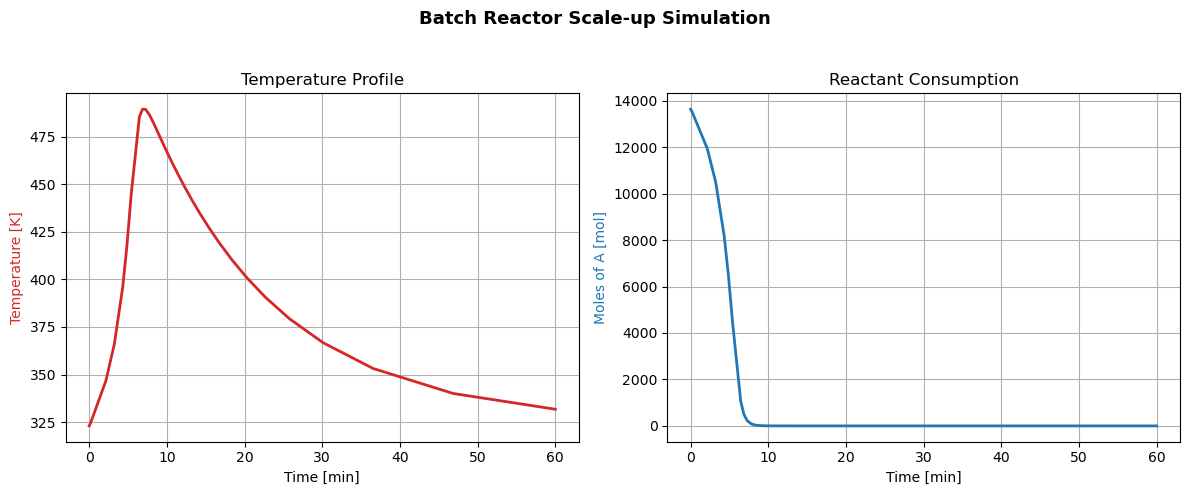

In [2]:
summary, data = batch_reactor_plot(height=105, T_cooling=325, adiabatic=False, plot=False)

# Extract arrays
time_min = data["Minutes"]
temp_K = data["Temperature [K]"]
moles_A = data["Moles of A [mol]"]

import matplotlib.pyplot as plt

# Two-column figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# ---- Left: Temperature vs Time ----
ax1.plot(time_min, temp_K, color="tab:red", lw=2)
ax1.set_xlabel("Time [min]")
ax1.set_ylabel("Temperature [K]", color="tab:red")
ax1.set_title("Temperature Profile")
ax1.grid(True)

# ---- Right: Moles of A vs Time ----
ax2.plot(time_min, moles_A, color="tab:blue", lw=2)
ax2.set_xlabel("Time [min]")
ax2.set_ylabel("Moles of A [mol]", color="tab:blue")
ax2.set_title("Reactant Consumption")
ax2.grid(True)

# Adjust layout for clarity
plt.suptitle("Batch Reactor Scale-up Simulation", fontsize=13, fontweight="bold")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


# BATCH REACTOR SCALE-UP

## Equations

### 1. Arrhenius Kinetics
$$
k(T) = k_0 \exp\!\left(-\frac{E}{R T}\right)
$$

Where:
- $k(T)$: Temperature-dependent rate constant (1/min),
- $k_0 = 3\times10^3~\mathrm{min^{-1}}$: Pre-exponential factor,
- $E = 3.0\times10^4~\mathrm{J\,mol^{-1}}$: Activation energy,
- $R = 8.314~\mathrm{J\,mol^{-1}\,K^{-1}}$: Universal gas constant.

---

### 2. Reaction Rate
$$
r_A = -k(T)\,C_A
$$

Where:
- $r_A$: Reaction rate (mol·cm⁻³·min⁻¹),
- $C_A$: Reactant concentration (mol·cm⁻³).

---

### 3. Reactor Geometry
$$
V = \frac{\pi}{4} h^3
$$

$$
A = \frac{\pi}{4}h^2 + \pi h^2 = \frac{5\pi}{4}h^2
$$

$$
\frac{A}{V} = \frac{5}{h}
$$

Where:
- $V$: Reactor volume (cm³),
- $A$: Heat-transfer area (cm²),
- $A/V$: Area-to-volume ratio (cm⁻¹).

---

### 4. Material Balance
$$
\frac{dn_A}{dt} = r_A \, V = -k(T)\,C_A\,V
$$

Where:
- $n_A$: Total moles of reactant A (mol),
- $V$: Reactor volume (cm³).

---

### 5. Energy Balance
$$
\frac{dT}{dt} =
\frac{\Delta H_{\text{rxn}} \, r_A \, V - U \, A \, (T - T_a)}
{C_A \, V \, C_p}
$$

Where:
- $\Delta H_{\text{rxn}} = -25{,}000~\mathrm{J\,mol^{-1}}$: Heat of reaction (exothermic),
- $U = 2.4~\mathrm{J\,cm^{-2}\,K^{-1}\,min^{-1}}$: Overall heat-transfer coefficient,
- $C_p = 125~\mathrm{J\,mol^{-1}\,K^{-1}}$: Molar heat capacity,
- $T_a$: Cooling temperature (K),
- $T$: Reactor temperature (K).

---

### 6. Initial Conditions
$$
T(0) = T_0 = 323~\mathrm{K}
$$

$$
n_A(0) = C_{A0} \, V = 0.015 \, V~(\mathrm{mol})
$$

---

### 7. Numerical Integration
The coupled differential equations are integrated over  
$t \in [0, 60]~\mathrm{min}$ using a **Runge–Kutta** solver (`scipy.integrate.solve_ivp`).

---

### 8. Interpretation
As the reactor size (height $h$) increases:
$$
\frac{A}{V} \downarrow \quad \Rightarrow \quad \text{Reduced cooling efficiency and higher } T_{\text{peak}}
$$

---

## Comparison Between Small- and Large-Scale Reactors

| **Aspect** | **Small-Scale Reactor (Lab / Pilot)** | **Large-Scale Reactor (Industrial)** | **Effect / Explanation** |
|:------------|:--------------------------------------|:-------------------------------------|:--------------------------|
| **Characteristic size (h)** | Small (10–20 cm) | Large (100–200 cm) | Volume grows faster than surface area ($V \propto h^3$, $A \propto h^2$). |
| **Area-to-volume ratio (A/V)** | High | Low | Smaller reactors remove heat more efficiently. |
| **Heat removal** | Efficient | Limited | Lower A/V reduces cooling capacity. |
| **Temperature rise** | Mild | Strong | Exothermic heat accumulates → possible runaway. |
| **Mixing** | Uniform | Non-uniform | Larger scale introduces gradients. |
| **Reaction control** | Stable | Harder | Greater thermal inertia slows control. |
| **Safety** | Easier | More critical | Higher energy inventory requires stricter safeguards. |
| **Instrumentation** | Simple | Complex | Industrial reactors need multiple sensors and control loops. |
| **Flexibility** | High | Low | Easier to modify operation in small-scale units. |
| **Typical use** | Research, kinetics | Production, optimization | Lab-scale data guide industrial design. |

---

### Key Insight
> - As reactor size increases, the **surface-to-volume ratio decreases**, reducing heat removal efficiency.  
> - This leads to **higher peak temperatures** and possible **thermal runaway**.  
> - Careful **cooling design** and **control strategies** are essential for safe scale-up.

---


| **Case**          | **Heat exchange** | **Temperature behavior**  | **Reason**                                                           |
| :---------------- | :---------------- | :------------------------ | :------------------------------------------------------------------- |
| **Adiabatic**     | None (U = 0)      | Sharp rise → **plateau**  | All heat retained; stops rising only when reaction stops.            |
| **Non-adiabatic** | Cooling to jacket | Rise → **peak** → decline | Competing heat generation and removal; eventually cooling dominates. |
